In [1]:
%pip install torch
%pip install torchvision
%pip install scikit-learn
%pip install pillow
%pip install matplotlib
%matplotlib inline

In [2]:
import numpy
import torch
import matplotlib.pyplot as plt

In [3]:
from torchvision.datasets import MNIST

train = MNIST("", download=True, train=True)
test = MNIST("", download=True, train=False)

In [4]:
X_train = train.data
y_train = train.targets
X_test = test.data
y_test = test.targets

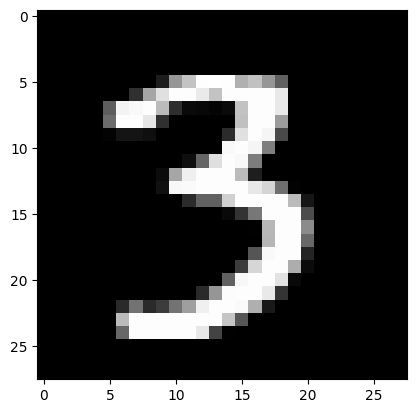

The number in the image is 3


In [5]:
image = X_train[10000]
label = y_train[10000]

plt.imshow(image, cmap="gray")
plt.show()
print("The number in the image is", label.numpy())

In [6]:
X_train = X_train.numpy()
y_train = y_train.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()

In [7]:
print("The size of X_train is", X_train.shape)
print("The size of y_train is", y_train.shape)
print("The size of X_test is", X_test.shape)
print("The size of y_test is", y_test.shape)

The size of X_train is (60000, 28, 28)
The size of y_train is (60000,)
The size of X_test is (10000, 28, 28)
The size of y_test is (10000,)


In [8]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print("The size of X_train is", X_train.shape)
print("The size of X_test is", X_test.shape)

The size of X_train is (60000, 784)
The size of X_test is (10000, 784)


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train.reshape(-1, 1)).view(-1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test.reshape(-1, 1)).view(-1)

In [11]:
import torch.nn as nn
import torch.nn.init as init


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 523)
        self.fc1_dropout = nn.Dropout(0.5)
        init.kaiming_normal_(self.fc1.weight)

        self.fc2 = nn.Linear(523, 348)
        self.bn2 = nn.BatchNorm1d(348)
        self.fc2_dropout = nn.Dropout(0.4)
        init.kaiming_normal_(self.fc2.weight)

        self.fc3 = nn.Linear(348, 232)
        self.bn3 = nn.BatchNorm1d(232)
        self.fc3_dropout = nn.Dropout(0.3)
        init.kaiming_normal_(self.fc3.weight)

        self.fc4 = nn.Linear(232, 155)
        self.bn4 = nn.BatchNorm1d(155)
        self.fc4_dropout = nn.Dropout(0.2)
        init.kaiming_normal_(self.fc4.weight)

        self.fc5 = nn.Linear(155, 103)
        self.bn5 = nn.BatchNorm1d(103)
        self.fc5_dropout = nn.Dropout(0.1)
        init.kaiming_normal_(self.fc4.weight)

        self.fc6 = nn.Linear(103, 10)
        init.xavier_normal_(self.fc5.weight)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc1_dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.fc2_dropout(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.fc3_dropout(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = torch.relu(x)
        x = self.fc4_dropout(x)

        x = self.fc5(x)
        x = self.bn5(x)
        x = torch.relu(x)
        x = self.fc5_dropout(x)

        x = self.fc6(x)

        return x

In [12]:
import torch.optim as optim

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [13]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

epochs = 25
losses = []
val_losses = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_val_loss = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        epoch_loss += loss.item() * inputs.size(0)

        loss.backward()
        optimizer.step()

    epoch_loss /= len(train_dataset)
    losses.append(epoch_loss)

    model.eval()

    with torch.no_grad():
        for inputs, targets in test_loader:
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs, targets)
            epoch_val_loss += val_loss.item() * inputs.size(0)

    epoch_val_loss /= len(test_dataset)
    val_losses.append(epoch_val_loss)

    model.train()

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch: {epoch + 1}/{epochs}, Training Loss: {losses[epoch]:.4f}, Validation Loss: {val_losses[epoch]:.4f}"
        )

Epoch: 5/25, Training Loss: 0.1557, Validation Loss: 0.1049
Epoch: 10/25, Training Loss: 0.1026, Validation Loss: 0.0842
Epoch: 15/25, Training Loss: 0.0819, Validation Loss: 0.0787
Epoch: 20/25, Training Loss: 0.0665, Validation Loss: 0.0765
Epoch: 25/25, Training Loss: 0.0590, Validation Loss: 0.0696


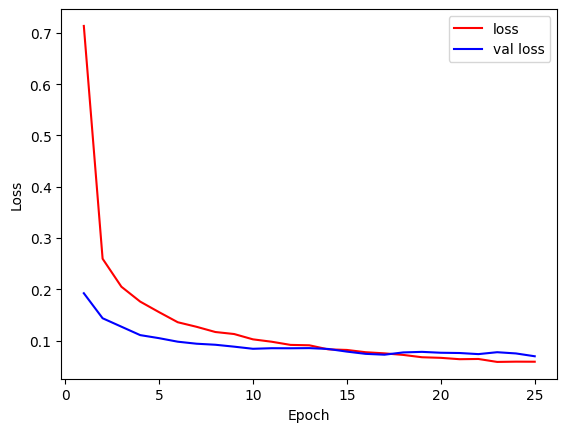

In [14]:
plt.plot(range(1, epochs + 1), losses, color="red", label="loss")
plt.plot(range(1, epochs + 1), val_losses, color="blue", label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
model.eval()

with torch.no_grad():
    train_pred = torch.argmax(model(X_train), dim=1)
    test_pred = torch.argmax(model(X_test), dim=1)

In [16]:
from sklearn.metrics import accuracy_score

print(f"The training accuracy is {100 * accuracy_score(y_train, train_pred):.2f}%")
print(f"The testing accuracy is {100 * accuracy_score(y_test, test_pred):.2f}%")

The training accuracy is 99.69%
The testing accuracy is 98.21%


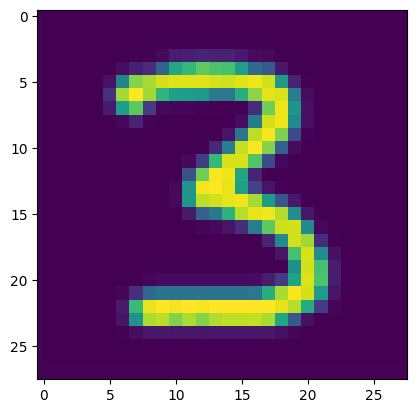

In [17]:
from PIL import Image

image = numpy.array(Image.open("number.png").resize((28, 28)).convert("L"))

plt.imshow(image)
plt.show()

In [18]:
image = image.reshape(1, -1)
image = scaler.transform(image)

In [19]:
model.eval()

with torch.no_grad():
    prediction = torch.argmax(model(torch.from_numpy(image).float()), dim=1)

print(
    "The model predicts the number", numpy.squeeze(prediction.numpy()), "in the image"
)

The model predicts the number 3 in the image
